In [2]:
import pandas as pd
import numpy as np
import pyod
np.set_printoptions(precision=3)

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pyod.models.knn import KNN

In [4]:
testing_set = pd.read_csv('C:/Users/andre/Desktop/test_set_unbalanced_60k.csv',sep=',',header=0)

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
testingSet = testing_set.values
for i in range (testingSet.shape[0]):
    if(testingSet[i, 84] == "ddos"):
        testingSet[i, 84] = 1
    else:
        testingSet[i, 84] = 0

#np.random.shuffle(testingSet)

for i in range (84, -1, -1):
    if(i != 75 and i != 5 and i!=73 and i!=3 and i!=26 and i!=72 and i!=84):
        testingSet = np.delete(testingSet, i, axis=1)

testingSet = testingSet.astype(float)
print(pd.DataFrame(testingSet))

for i in range (2*10**4-1, 0, -1):
    for j in range(0, 6):
        testingSet[i, j] = float(testingSet[i, j])
        if (np.isinf(testingSet[i, j]) or np.isnan(testingSet[i, j])):
            testingSet = np.delete(testingSet, i, axis=0)
            
y_test = testingSet[:, 6].astype(int)
testingSet = np.delete(testingSet, 6, axis=1)

#sigma2 = np.var(testingSet,axis=0,ddof=1)
#sigma = np.sqrt(sigma2)
#mu = np.mean(testingSet,axis=0)
#testingSet = testingSet - mu
#for i in range (sigma.size):
#    if(sigma[i] == 0):
#        sigma[i] = 1
#testingSet = testingSet/sigma

             0        1       2       3        4     5    6
0      56387.0     80.0    14.0  8192.0    211.0  20.0  1.0
1         80.0  39084.0     8.0    -1.0    211.0   0.0  1.0
2      59040.0     80.0  2126.0    -1.0  32738.0   0.0  1.0
3         80.0  36730.0     8.0    -1.0    211.0   0.0  1.0
4      41800.0     21.0     2.0    -1.0      0.0   0.0  1.0
...        ...      ...     ...     ...      ...   ...  ...
59995    445.0  52767.0   115.0   259.0     -1.0  20.0  0.0
59996  50452.0     80.0    12.0  8192.0    141.0  20.0  0.0
59997  49404.0     53.0  1500.0    -1.0     -1.0   8.0  0.0
59998  53550.0     53.0   300.0    -1.0     -1.0   8.0  0.0
59999    443.0  52438.0     1.0   496.0     -1.0  20.0  0.0

[60000 rows x 7 columns]


In [6]:
from pyod.utils.data import evaluate_print
from pyod.models.lof import LOF 
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD


On Test Data - LOF:
1407  |  7978
8849  |  41766 

LOF ROC:0.4897, precision @ rank n:0.1527


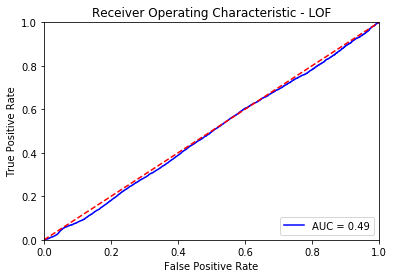


On Test Data - CBLOF:
2929  |  7271
7327  |  42473 

CBLOF ROC:0.5941, precision @ rank n:0.2862


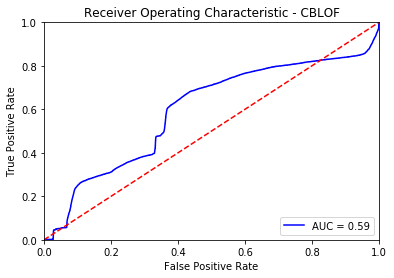


On Test Data - HBOS:
7357  |  1793
2899  |  47951 

HBOS ROC:0.8896, precision @ rank n:0.804


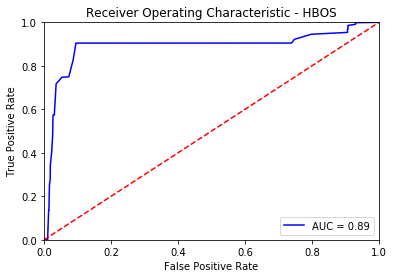


On Test Data - kNN:
3142  |  6141
7114  |  43603 

kNN ROC:0.5769, precision @ rank n:0.3281


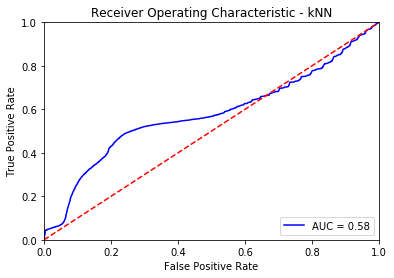


On Test Data - AvgKNN:
2860  |  5297
7396  |  44447 

AvgKNN ROC:0.5618, precision @ rank n:0.3338


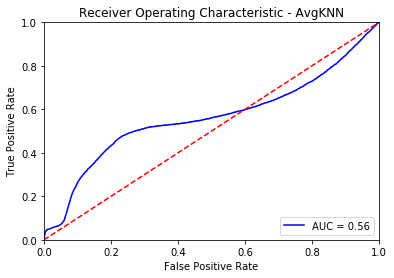


On Test Data - MedKNN:
2987  |  5732
7269  |  44012 

MedKNN ROC:0.5544, precision @ rank n:0.3341


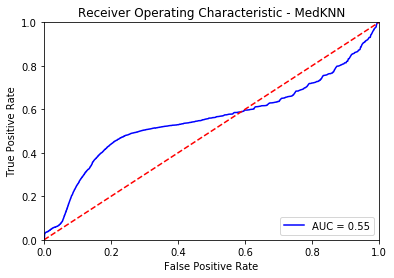


On Test Data - SOD:
1984  |  8216
8272  |  41528 

SOD ROC:0.5026, precision @ rank n:0.1941


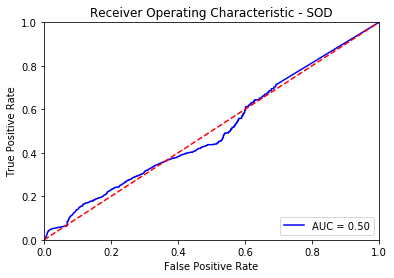

In [7]:
outliers_fraction = 0.17

#Métodos que não requerem treinamento em outro dataset
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  Apresentou erros de execução.
    'LOF': LOF(contamination = outliers_fraction),
    'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'kNN': KNN(method='largest', contamination= outliers_fraction),
    'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    'MedKNN': KNN(method='median', contamination= outliers_fraction),
    'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(testingSet)

    #####################################################################

    y_test_pred = clf.predict(testingSet)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(testingSet)  # outlier scores

    #####################################################################

    print("\nOn Test Data - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(y_test.size):
        if(y_test[i] == 1 and y_test_pred[i] == 1):
            truePositive = truePositive+1
        elif (y_test[i] == 0 and y_test_pred[i] == 0):
            trueNegative = trueNegative+1
        elif (y_test[i] == 0 and y_test_pred[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print(truePositive, " | ", falsePositive)
    print(falseNegative, " | ", trueNegative,"\n")

    evaluate_print(clf_name, y_test, y_test_scores)

    #####################################################################

    import sklearn.metrics as metrics

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_scores)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic - '+clf_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()